In [1]:
import pandas as pd
import numpy as np
import datetime
from data import Data
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.vector_ar.vecm import VECM, select_order, select_coint_rank
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, rmspe, aic
from statsmodels.graphics.tsaplots import  plot_acf, plot_pacf, plot_predict

## Relationship with Macro Economic Variable

In [2]:
all_data = Data()
hose, hnx = all_data.hose, all_data.hnx
monthly_macro_df =  all_data.get_macro_df()

In [3]:
# Filter out month end values
def filter_month_end(og_df):
    df = pd.DataFrame()
    df["Date"] = og_df.index
    df["Month"] = [ i.month for i in og_df.index ]
    df["Year"] = [ i.year for i in  og_df.index ]
    month_df = df[["Month","Year","Date"]].groupby(["Year","Month"], as_index = False ).agg({"Date":"max"})

    return month_df.merge(og_df, on = "Date", how = "left", suffixes = [None, "_x"])[["Year", "Month", "Date", "Close"]]

# Merge index data with macroeconomic dat
def make_macro_df(index_month_df, monthly_macro_df, index_name, vars_, dropna = False):
    index_macro = index_month_df.merge(monthly_macro_df, on = ["Year", "Month"],
                                         how = "inner", suffixes = [None, "_x"])
    index_macro.index = pd.to_datetime(index_macro[['Year', 'Month']].assign(DAY=1))
    index_macro = index_macro[vars_]
    if dropna:
        index_macro = index_macro.dropna()
    index_macro.set_index(pd.date_range(start = index_macro.index.min(),
                                         periods =len(index_macro),
                                         freq="M"), inplace= True)
    index_macro.rename(columns = {"Close":index_name}, inplace = True)
    return index_macro

# Filter month end and keep only values from 2005 onwards
hose_month = filter_month_end(hose)
hose_month = hose_month[hose_month["Date"] >= pd.to_datetime("2006-01-01")]
hnx_month = filter_month_end(hnx)
hnx_month = hnx_month[hnx_month["Date"] >= pd.to_datetime("2006-01-01")]

In [4]:
# Filter out relevant variables
monthly_macro_df = monthly_macro_df[['Time', 'Economic Activity, Industrial Production, Index',
                        'Financial, Interest Rates, Deposit, Percent per annum',
                        'Exchange Rates, Domestic Currency per SDR, Period Average',
                        'Prices, Consumer Price Index, All items, Index']]

macro_vals ={'Economic Activity, Industrial Production, Index':"IIP",
                'Exchange Rates, Domestic Currency per SDR, Period Average':"EXR_SDR",
                'Financial, Interest Rates, Deposit, Percent per annum':"IR_DEPOSIT", 
                'Prices, Consumer Price Index, All items, Index':"CPI" }

monthly_macro_df.rename(columns = macro_vals, inplace=True)
monthly_macro_df["Time"] = pd.to_datetime( monthly_macro_df["Time"])
monthly_macro_df["Month"] = [ i.month for i in monthly_macro_df["Time"]]
monthly_macro_df["Year"] = [ i.year for i in monthly_macro_df["Time"]]

monthly_macro_df.head()

,Time,IIP,IR_DEPOSIT,EXR_SDR,CPI,Month,Year
0,2000-01-01,NaN,3.6,19241.56,48.57,1,2000
1,2000-02-01,NaN,3.6,18905.93,49.33,2,2000
2,2000-03-01,NaN,3.6,18881.99,48.77,3,2000
3,2000-04-01,NaN,3.6,18832.44,48.41,4,2000
4,2000-05-01,NaN,3.6,18452.45,48.13,5,2000


In [5]:
# Merge month end values of stock indeces with macroeconomic variables and scale by taking log
hose_macro = make_macro_df( hose_month,monthly_macro_df, "VN-INDEX", ["Close","EXR_SDR", "IIP","IR_DEPOSIT", "CPI"])
hose_macro = np.log(hose_macro)
hnx_macro = make_macro_df( hnx_month,monthly_macro_df, "HNX-INDEX", ["Close","EXR_SDR", "IIP","IR_DEPOSIT", "CPI"])
hnx_macro = np.log(hnx_macro)

## Testing all variables for Unit Root

In [6]:
# Conduct and print result of Augmented Dickey Fuller Test
def augmented_dickey_fuller_statistics(time_series):
    result = adfuller(time_series.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

Augmented Dickey-Fuller Test: VN-INDEX
ADF Statistic: -1.581682
p-value: 0.492788
Critical Values:
	1%: -3.470
	5%: -2.879
	10%: -2.576
Augmented Dickey-Fuller Test: Differenced VN-NDEX
ADF Statistic: -4.653414
p-value: 0.000103
Critical Values:
	1%: -3.470
	5%: -2.879
	10%: -2.576


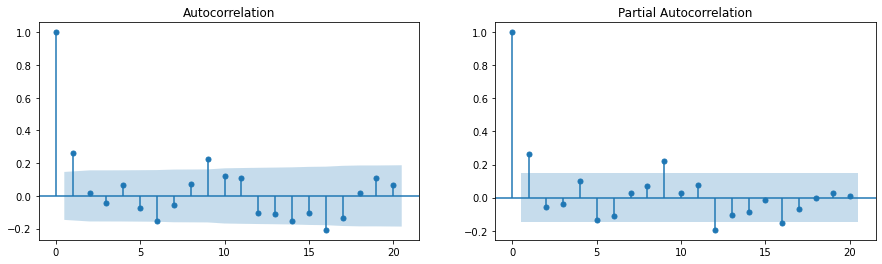

In [7]:
# Stock Indeces
print(f'Augmented Dickey-Fuller Test: VN-INDEX')
augmented_dickey_fuller_statistics(hose_macro["VN-INDEX"])
print(f'Augmented Dickey-Fuller Test: Differenced VN-NDEX')
augmented_dickey_fuller_statistics(hose_macro["VN-INDEX"].diff().dropna())
# Graph hose_macro
fig, axes = plt.subplots(1, 2, figsize=(15,4))
fig = plot_acf(hose_macro['VN-INDEX'].diff()[1:], lags=20, ax=axes[0])
fig = plot_pacf(hose_macro['VN-INDEX'].diff()[1:], lags=20, ax=axes[1])

Augmented Dickey-Fuller Test: HNX-INDEX
ADF Statistic: -2.290361
p-value: 0.175096
Critical Values:
	1%: -3.469
	5%: -2.879
	10%: -2.576
Augmented Dickey-Fuller Test: Differenced HNX-INDEX
ADF Statistic: -3.816661
p-value: 0.002741
Critical Values:
	1%: -3.471
	5%: -2.879
	10%: -2.576


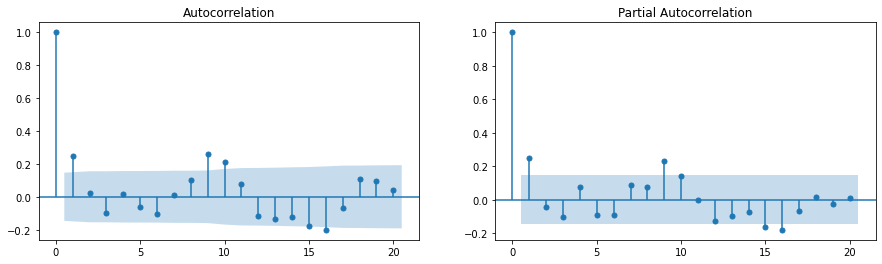

In [8]:
print(f'Augmented Dickey-Fuller Test: HNX-INDEX')
augmented_dickey_fuller_statistics(hnx_macro["HNX-INDEX"])
print(f'Augmented Dickey-Fuller Test: Differenced HNX-INDEX')
augmented_dickey_fuller_statistics(hnx_macro["HNX-INDEX"].diff().dropna())
#Graph hnx-index
fig, axes = plt.subplots(1, 2, figsize=(15,4))
fig = plot_acf(hnx_macro['HNX-INDEX'].diff()[1:], lags=20, ax=axes[0])
fig = plot_pacf(hnx_macro['HNX-INDEX'].diff()[1:], lags=20, ax=axes[1])

In [9]:
# Macroeconomic Variables
for col in ["IIP", "IR_DEPOSIT","EXR_SDR","CPI"]:
    print(f'Augmented Dickey-Fuller Test: {col}')
    augmented_dickey_fuller_statistics(hose_macro[col].dropna())
    print(f'Augmented Dickey-Fuller Test: Differenced {col}')
    augmented_dickey_fuller_statistics(hose_macro[col].diff().dropna())
    print("\n")

Augmented Dickey-Fuller Test: IIP
ADF Statistic: -3.010515
p-value: 0.033924
Critical Values:
	1%: -3.483
	5%: -2.885
	10%: -2.579
Augmented Dickey-Fuller Test: Differenced IIP
ADF Statistic: -2.706793
p-value: 0.072870
Critical Values:
	1%: -3.483
	5%: -2.885
	10%: -2.579


Augmented Dickey-Fuller Test: IR_DEPOSIT
ADF Statistic: -1.161606
p-value: 0.689890
Critical Values:
	1%: -3.468
	5%: -2.878
	10%: -2.576
Augmented Dickey-Fuller Test: Differenced IR_DEPOSIT
ADF Statistic: -5.990702
p-value: 0.000000
Critical Values:
	1%: -3.469
	5%: -2.878
	10%: -2.576


Augmented Dickey-Fuller Test: EXR_SDR
ADF Statistic: -2.184634
p-value: 0.211870
Critical Values:
	1%: -3.468
	5%: -2.878
	10%: -2.576
Augmented Dickey-Fuller Test: Differenced EXR_SDR
ADF Statistic: -9.228280
p-value: 0.000000
Critical Values:
	1%: -3.468
	5%: -2.878
	10%: -2.576


Augmented Dickey-Fuller Test: CPI
ADF Statistic: -3.198864
p-value: 0.020051
Critical Values:
	1%: -3.469
	5%: -2.878
	10%: -2.576
Augmented Dickey-Fu

In [10]:
# Excluding IIP which is not Unit Root
hose_macro = make_macro_df( hose_month,monthly_macro_df, "VN-INDEX", ["Close","EXR_SDR", "IR_DEPOSIT", "CPI"], dropna=True)
hose_macro = np.log(hose_macro)
hnx_macro = make_macro_df( hnx_month,monthly_macro_df, "HNX-INDEX", ["Close","EXR_SDR", "IR_DEPOSIT", "CPI"], dropna=True)
hnx_macro = np.log(hnx_macro)

## Vector Error Correction Model
### Fitting VECM model with VN-INDEX

In [11]:
select_order(hose_macro, maxlags = 10, deterministic = "colo").summary()

,AIC,BIC,FPE,HQIC
0,-29.60,-29.08,1.396e-13,-29.39
1,-30.39,-29.58*,6.340e-14,-30.06*
2,-30.43*,-29.32,6.079e-14*,-29.98
3,-30.41,-29.01,6.212e-14,-29.84
4,-30.35,-28.64,6.651e-14,-29.66
5,-30.25,-28.25,7.365e-14,-29.44
6,-30.25,-27.95,7.441e-14,-29.31
7,-30.15,-27.56,8.267e-14,-29.10
8,-30.09,-27.20,8.810e-14,-28.92
9,-30.12,-26.94,8.649e-14,-28.83


In [12]:
vec_rank1 = select_coint_rank(hose_macro.loc[:"2020-03-01"], 
                              det_order = 1,
                              k_ar_diff = 1, 
                              method = 'maxeig',
                              signif=0.05)
vec_rank1.summary()

r_0,r_1,test statistic,critical value
0,1,44.42,30.82
1,2,14.09,24.25


In [13]:
vecm = VECM(endog = hose_macro.loc[:"2020-03-21"], 
            k_ar_diff = 1, 
            coint_rank = 1, 
            deterministic = "colo")
hose_vecm_fit = vecm.fit()
hose_vecm_fit.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
const,-3.3820,0.691,-4.893,0.000,-4.737,-2.027
lin_trend,0.0023,0.000,4.587,0.000,0.001,0.003
L1.VN-INDEX,0.2744,0.068,4.041,0.000,0.141,0.408
L1.EXR_SDR,-0.1256,0.508,-0.247,0.805,-1.122,0.871
L1.IR_DEPOSIT,0.1969,0.111,1.766,0.077,-0.022,0.415
L1.CPI,-0.9337,0.976,-0.957,0.339,-2.847,0.979
,coef,std err,z,P>|z|,[0.025,0.975]
const,0.0387,0.106,0.365,0.715,-0.169,0.247
lin_trend,-5.014e-05,7.57e-05,-0.662,0.508,-0.000,9.83e-05
L1.VN-INDEX,0.0024,0.010,0.230,0.818,-0.018,0.023


In [14]:
hose_vecm_fit.test_granger_causality( caused = "VN-INDEX", causing= ['EXR_SDR', 'IR_DEPOSIT', 'CPI'], signif = 0.05).summary() 

Test statistic,Critical value,p-value,df
1.882,2.113,0.082,"(6, 612)"


In [15]:
hose_vecm_fit.test_inst_causality( causing= [ 'EXR_SDR', 'IR_DEPOSIT', 'CPI']).summary() 

Test statistic,Critical value,p-value,df
9.370,7.815,0.025,3


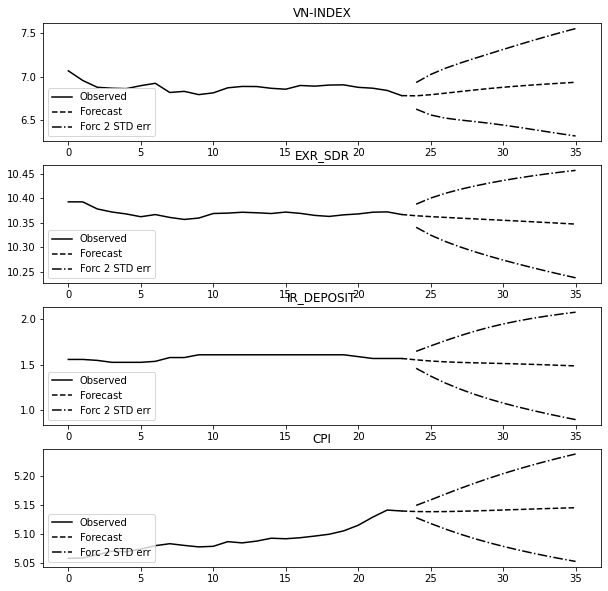

In [42]:
hose_vecm_fit.plot_forecast(steps = 12, n_last_obs = 24)

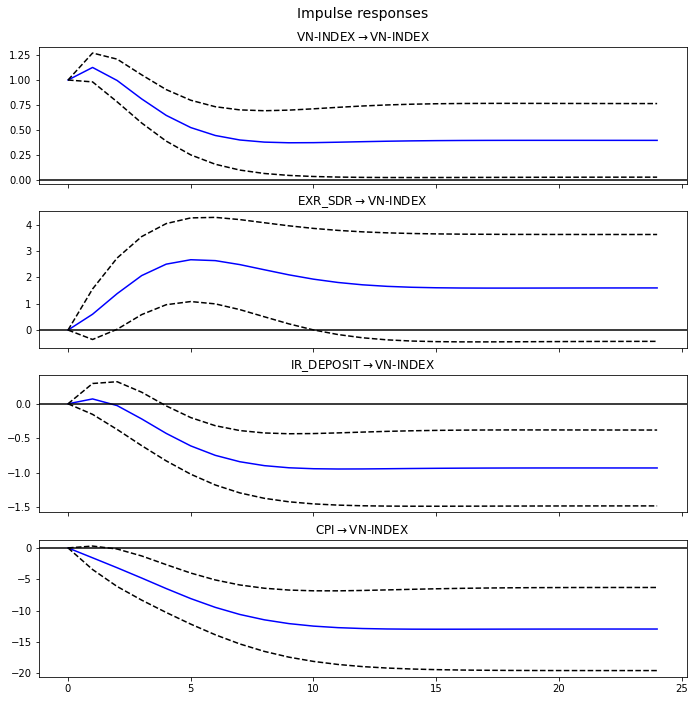

In [17]:
_ = hose_vecm_fit.irf(24).plot(response = "VN-INDEX", orth=False)

In [18]:
hose_vecm_fit.test_normality().summary()

Test statistic,Critical value,p-value,df
1149.,15.51,0.000,8


In [19]:
hose_vecm_fit.test_whiteness(nlags=15, adjusted=True).summary()

Test statistic,Critical value,p-value,df
299.9,255.6,0.000,220


### HNX

In [20]:
select_order(hnx_macro.loc[:"2020-03-21"], maxlags = 10, deterministic="colo").summary()

,AIC,BIC,FPE,HQIC
0,-29.41,-28.87,1.690e-13,-29.19
1,-30.17,-29.32*,7.927e-14,-29.82*
2,-30.14,-28.98,8.139e-14,-29.67
3,-30.19*,-28.72,7.809e-14*,-29.59
4,-30.11,-28.34,8.430e-14,-29.39
5,-30.07,-27.99,8.822e-14,-29.23
6,-30.09,-27.70,8.732e-14,-29.12
7,-29.96,-27.25,1.007e-13,-28.86
8,-29.93,-26.92,1.042e-13,-28.71
9,-29.94,-26.62,1.046e-13,-28.60


In [21]:
vec_rank1 = select_coint_rank(hnx_macro.loc[:"2020-03-21"], 
                              det_order = 1,
                              k_ar_diff = 1, 
                              method = 'maxeig',
                              signif=0.05)
vec_rank1.summary()

r_0,r_1,test statistic,critical value
0,1,48.17,30.82
1,2,19.03,24.25


In [22]:
vecm = VECM(endog = hnx_macro.loc[:"2020-03-21"], 
            k_ar_diff = 1, 
            coint_rank = 1, 
            deterministic = "colo")
hnx_vecm_fit = vecm.fit()
hnx_vecm_fit.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
const,2.9476,0.426,6.916,0.000,2.112,3.783
lin_trend,0.0028,0.000,6.298,0.000,0.002,0.004
L1.HNX-INDEX,0.2641,0.069,3.827,0.000,0.129,0.399
L1.EXR_SDR,-0.0751,0.576,-0.130,0.896,-1.204,1.054
L1.IR_DEPOSIT,0.2106,0.131,1.603,0.109,-0.047,0.468
L1.CPI,0.1966,1.175,0.167,0.867,-2.106,2.500
,coef,std err,z,P>|z|,[0.025,0.975]
const,0.0390,0.056,0.700,0.484,-0.070,0.148
lin_trend,6.598e-06,5.77e-05,0.114,0.909,-0.000,0.000
L1.HNX-INDEX,-0.0033,0.009,-0.364,0.716,-0.021,0.014


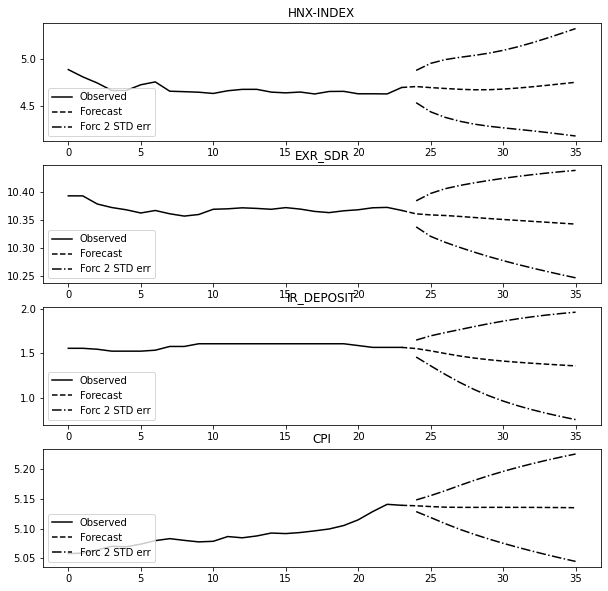

In [41]:
hnx_vecm_fit.plot_forecast(steps = 12, n_last_obs = 24 )

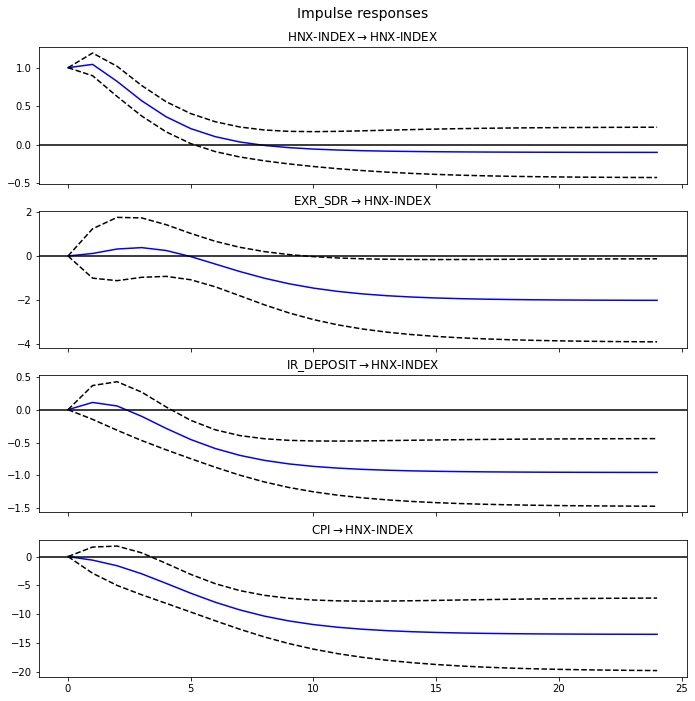

In [24]:
_ = hnx_vecm_fit.irf(24).plot(response = "HNX-INDEX", orth=False)

In [25]:
hnx_vecm_fit.test_granger_causality( caused = "HNX-INDEX", causing= ['EXR_SDR', 'IR_DEPOSIT', 'CPI']).summary() 

Test statistic,Critical value,p-value,df
1.053,2.113,0.390,"(6, 612)"


In [26]:
hnx_vecm_fit.test_inst_causality( causing= [ 'EXR_SDR', 'IR_DEPOSIT', 'CPI']).summary() 

Test statistic,Critical value,p-value,df
16.90,7.815,0.001,3


In [27]:
hnx_vecm_fit.test_normality().summary()

Test statistic,Critical value,p-value,df
1589.,15.51,0.000,8


In [28]:
hnx_vecm_fit.test_whiteness(nlags=5, adjusted=True).summary()

Test statistic,Critical value,p-value,df
95.67,79.08,0.002,60


### Evaluating Predictions

In [29]:
hose_predict = hose_vecm_fit.predict(steps = 10)
hose_te_pred = [i[0] for i in hose_predict]
print("VN-INDEX:")
print("Out sample RMSE:", rmse(hose_macro.loc["2020-03-01":,"VN-INDEX"], hose_te_pred))
print("Out sample RMSPE:", rmspe(hose_macro.loc["2020-03-01":,"VN-INDEX"], hose_te_pred))

VN-INDEX:
Out sample RMSE: 0.12978871548718152
Out sample RMSPE: 0.19621247886300355


In [30]:
hnx_predict = hnx_vecm_fit.predict(steps = 10)
hnx_te_pred = [i[0] for i in hnx_predict]
print("HNX-INDEX:")
print("Out sample RMSE:", rmse(hnx_macro.loc["2020-03-01":,"HNX-INDEX"], hnx_te_pred))
print("Out sample RMSPE:", rmspe(hnx_macro.loc["2020-03-01":,"HNX-INDEX"], hnx_te_pred))

HNX-INDEX:
Out sample RMSE: 0.23378512074130958
Out sample RMSPE: 0.4557339057236238


## Fitting SARIMAX Models

In [31]:
def plot_predictions(data, full_res, cutoff, dynamic_cutoff,title, ylable):
    # One-step ahead
    predict = full_res.get_prediction()
    predict_ci = predict.conf_int()
    # Dynamic predictions
    predict_dy = full_res.get_prediction(dynamic= dynamic_cutoff)
    predict_dy_ci = predict_dy.conf_int()
    # Graph
    fig, ax = plt.subplots(figsize=(9,4))
    npre = 4
    ax.set(title=title, xlabel='Date', ylabel=ylable)

    # Plot data points
    data.loc[cutoff:, title].plot(ax=ax, style='o', label='Observed')

    # Plot predictions
    # One-step-ahead
    predict.predicted_mean.loc[cutoff:].plot(ax=ax, style='r--', label='One-step-ahead forecast')
    ci = predict_ci.loc[cutoff:]
    ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
    # Dynamix
    predict_dy.predicted_mean.loc[cutoff:].plot(ax=ax, style='g', label=f'Dynamic forecast({dynamic_cutoff}) ')
    ci = predict_dy_ci.loc[cutoff:]
    ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)
    legend = ax.legend(loc='lower right')

### HOSE

In [32]:
endog = hose_macro.loc[:,"VN-INDEX"]
exog = hose_macro.loc[:,['EXR_SDR', 'IR_DEPOSIT', 'CPI'] ]
# Fit the model with data exluding the last 10 months of 2020
hose_mod = sm.tsa.statespace.SARIMAX(endog.loc[:"2020-03-01"], exog.loc[:"2020-03-01"], order=(1,1,1))
hose_fit_tr = hose_mod.fit(disp=False)
print(hose_fit_tr.summary())

                               SARIMAX Results                                
Dep. Variable:               VN-INDEX   No. Observations:                  170
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 174.928
Date:                Thu, 15 Apr 2021   AIC                           -337.857
Time:                        17:19:07   BIC                           -319.077
Sample:                    01-31-2006   HQIC                          -330.236
                         - 02-29-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
EXR_SDR        0.1424      0.461      0.309      0.757      -0.760       1.045
IR_DEPOSIT    -0.1171      0.122     -0.960      0.337      -0.356       0.122
CPI           -0.6818      0.732     -0.931      0.3

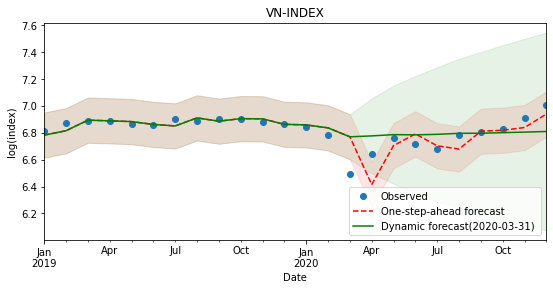

In [33]:
# Get predictions of left-out data using previously fit model
hose_full_mod = sm.tsa.statespace.SARIMAX(endog, exog=exog, order=(1,1,1))
hose_fit_full = hose_full_mod.filter(hose_fit_tr.params)
plot_predictions(hose_macro, hose_fit_full, "2019-01-31", "2020-03-31", "VN-INDEX", "log(index)")

### HNX

In [34]:
endog = hnx_macro.loc[:,"HNX-INDEX"]
exog = hnx_macro.loc[:,['EXR_SDR', 'IR_DEPOSIT', 'CPI'] ]

# Fit the model with data exluding the last 10 months of 2020
hnx_mod = sm.tsa.statespace.SARIMAX(endog.loc[:"2020-03-01"], exog.loc[:"2020-03-01"], order=(1,1,1))
hnx_fit_tr = hnx_mod.fit(disp=False)
print(hnx_fit_tr.summary())

                               SARIMAX Results                                
Dep. Variable:              HNX-INDEX   No. Observations:                  170
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 147.168
Date:                Thu, 15 Apr 2021   AIC                           -282.335
Time:                        17:19:09   BIC                           -263.556
Sample:                    01-31-2006   HQIC                          -274.714
                         - 02-29-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
EXR_SDR        0.2370      0.617      0.384      0.701      -0.973       1.447
IR_DEPOSIT    -0.0382      0.152     -0.252      0.801      -0.335       0.259
CPI           -3.0353      0.888     -3.419      0.0

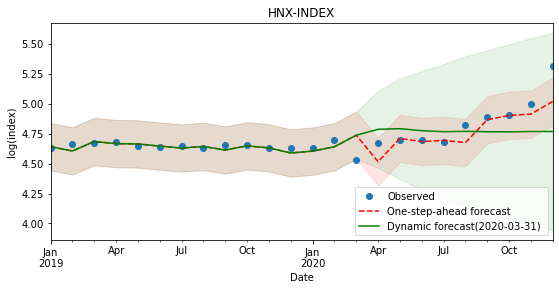

In [35]:
# Get predictions of left-out data using previously fit model
hnx_full_mod = sm.tsa.statespace.SARIMAX(endog, exog=exog, order=(1,1,1))
hnx_fit_full = hnx_full_mod.filter(hnx_fit_tr.params)
plot_predictions(hnx_macro, hnx_fit_full, "2019-01-31", "2020-03-31", "HNX-INDEX", "log(index)")

### Evaluating models

In [36]:
hose_predict = hose_fit_full.get_prediction()
hose_tr_pred = hose_predict.predicted_mean.loc[:"2020-02-28"]
hose_te_pred = hose_predict.predicted_mean.loc["2020-02-28":]
print("VN-INDEX:")
print("In sample RMSE:", rmse(hose_macro.loc[:"2020-02-28","VN-INDEX"], hose_tr_pred))
print("In sample RMSPE:", rmspe(hose_macro.loc[:"2020-02-28","VN-INDEX"], hose_tr_pred))
print("Out sample RMSE:", rmse(hose_macro.loc["2020-02-28":,"VN-INDEX"], hose_te_pred))
print("Out sample RMSPE:", rmspe(hose_macro.loc["2020-02-28":,"VN-INDEX"], hose_te_pred))

VN-INDEX:
In sample RMSE: 0.5733241808122295
In sample RMSPE: 0.9963486822746342
Out sample RMSE: 0.12096547605160198
Out sample RMSPE: 0.18309394883947255


In [ ]:
hnx_predict = hnx_fit_full.get_prediction()
hnx_tr_pred = hnx_predict.predicted_mean.loc[:"2020-02-28"]
hnx_te_pred = hnx_predict.predicted_mean.loc["2020-02-28":]
print("HNX-INDEX:")
print("In sample RMSE:", rmse(hnx_macro.loc[:"2020-02-28","HNX-INDEX"], hnx_tr_pred))
print("In sample RMSPE:", rmspe(hnx_macro.loc[:"2020-02-28","HNX-INDEX"], hnx_tr_pred))
print("Out sample RMSE:", rmse(hnx_macro.loc["2020-02-28":,"HNX-INDEX"], hnx_te_pred))
print("Out sample RMSPE:", rmspe(hnx_macro.loc["2020-02-28":,"HNX-INDEX"], hnx_te_pred))